# Applied Data Science Capstone Project

## Table of Contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## 1. Introduction
This notebook contains our work for the capstone project for the IBM Applied Data Science Specialization.

Specificallt, it presents the methodology we followed in order to predict the most appropriate neighborhoods in London to open a new Mediterranean fusion restaurant. Mediterranean cuisine is getting a lot of traction as a diet which provides a plethora of health benefits, since it is based on large quantities of fresh fruits, vegetables, nuts, fish, and olive oil. Moreover, modern societies promote more and more a healthy and balanced way of life. This is especially profound in high population capitals of the western world in which the everyday routine is hectic and large segments of the population suffer from continuous stress and psychological issues. These people, especially the ones with higher income, continuously seek for new experiences that stimulate their senses in unique and unprecedented ways. 

Thus, considering the above, if an entrepreneur would consider investing in the food business, a restaurant based on the Mediterranean cuisine would be an ideal candidate. Also, London is one of the most populated European capitals with a high percentage of people that are financially stable. Finally, modifying the restaurant cuisine with a fusion element, will further help the investment to succeed as it provides a niche variation in the taste and appearance of the menu.

## 2. Data
In our analysis, we are going to extract the neighborhoods of London from [Wikipedia](https://en.wikipedia.org/wiki/List_of_areas_of_London). 

Next, we are going to use data from the [YouGov’s report](https://yougov.co.uk/topics/politics/articles-reports/2015/10/13/mapped-londons-food-tastes) to exclude areas that this type or restaurant would not be an ideal option. 

Finally, we are going to use [Foursquare API](https://developer.foursquare.com/docs) to analyze the existing venues in the most interesting neighborhoods and use these results to identify the most appropriate neighborhoods to open our restaurant.

> **Assumption**
We assume that all necessary packages have been installed and are available to use. In our setup, we use conda to manage our development environment and python package management.

Before we proceed to data acquisition and analysis, we first import all the python packages that are required to perform our analysis.

In [1]:
#import necessary libaries
import pandas as pd
import numpy as np

# networking
import requests

# parsing
from bs4 import BeautifulSoup
import re

# geocoding
import geocoder

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize 

# import k-means from clustering stage
from sklearn.cluster import KMeans

# map rendering library
import folium 

# general libs
import time
import json

print('Libraries imported successfully!')

Libraries imported successfully!


### Data Acquisition and  Cleanup
In this section, we present the methodology we used to acquire the necessary data. We also describe how we process the data to be used in the next phases of our analysis.

First, we get London neighbourhoods data from Wikipedia.

In [2]:
# read webpage content and convert table data to pandas dataframe
res = requests.get("https://en.wikipedia.org/wiki/List_of_areas_of_London")
soup = BeautifulSoup(res.content,'html.parser')

# search for all tables in page and keep the second one
table = soup.find_all('table')[1]

# read_html returns a list by default, thus we get the first element
df = pd.read_html(str(table))[0] 
df

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728
...,...,...,...,...,...,...
528,Woolwich,Greenwich,LONDON,SE18,020,TQ435795
529,Worcester Park,"Sutton, Kingston upon Thames",WORCESTER PARK,KT4,020,TQ225655
530,Wormwood Scrubs,Hammersmith and Fulham,LONDON,W12,020,TQ225815
531,Yeading,Hillingdon,HAYES,UB4,020,TQ115825


We remove unnecessary trailing spaces, tabs, we drop columns that we do not need, and we rename some columns.

In [3]:
# strip column names
df.rename(columns=lambda x: x.strip(), inplace=True)
df.rename(columns=lambda x: x.replace('\xa0', ' '), inplace=True)

# we drop the columns that we do not need
df.drop(['Dial code', 'OS grid ref'], axis=1, inplace=True)

# rename columns
df.rename(columns={'London borough': 'Borough', 'Post town': 'Post-town', 'Postcode district':'Postcode'}, inplace=True)
df

,Location,Borough,Post-town,Postcode
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4"
2,Addington,Croydon[8],CROYDON,CR0
3,Addiscombe,Croydon[8],CROYDON,CR0
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14"
...,...,...,...,...
528,Woolwich,Greenwich,LONDON,SE18
529,Worcester Park,"Sutton, Kingston upon Thames",WORCESTER PARK,KT4
530,Wormwood Scrubs,Hammersmith and Fulham,LONDON,W12
531,Yeading,Hillingdon,HAYES,UB4


We see that there are values that have references numbers (e.g. \[7\]) and also in cells that contain multiple boroughs, the 'and' word is used. We fix this.

In [4]:
# we cleanup borough from reference numbers (e.g. [7])
df['Borough'] = df['Borough'].map(lambda x: re.sub('\[.*?\]', '', x))

# we replace 'and' with comma
df['Borough'] = df['Borough'].map(lambda x: x.replace(' and', ','))
df

,Location,Borough,Post-town,Postcode
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2
1,Acton,"Ealing, Hammersmith, Fulham",LONDON,"W3, W4"
2,Addington,Croydon,CROYDON,CR0
3,Addiscombe,Croydon,CROYDON,CR0
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14"
...,...,...,...,...
528,Woolwich,Greenwich,LONDON,SE18
529,Worcester Park,"Sutton, Kingston upon Thames",WORCESTER PARK,KT4
530,Wormwood Scrubs,"Hammersmith, Fulham",LONDON,W12
531,Yeading,Hillingdon,HAYES,UB4


We see that some rows have more than one postcodes. We are going to split them into mutliple rows. All the other columns of the new rows will be copied from the original row.

In [5]:
df = df.assign(Postcode=df['Postcode'].str.split(',')).explode('Postcode')

In order to minimize the API calls that will be needed towards the Foursqaure API, we keep only the locations with Post-town LONDON.

In [6]:
df.drop(df[ df['Post-town'] != 'LONDON' ].index , inplace=True)
df

,Location,Borough,Post-town,Postcode
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2
1,Acton,"Ealing, Hammersmith, Fulham",LONDON,W3
1,Acton,"Ealing, Hammersmith, Fulham",LONDON,W4
6,Aldgate,City,LONDON,EC3
7,Aldwych,Westminster,LONDON,WC2
...,...,...,...,...
523,Woodford,Redbridge,LONDON,IG8
523,Woodford,Redbridge,LONDON,E18
527,Woodside Park,Barnet,LONDON,N12
528,Woolwich,Greenwich,LONDON,SE18


We do not need column Post-town anymore, thus we drop it from the dataframe.

In [7]:
df.drop(['Post-town'], axis=1, inplace=True)
df

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith, Fulham",W3
1,Acton,"Ealing, Hammersmith, Fulham",W4
6,Aldgate,City,EC3
7,Aldwych,Westminster,WC2
...,...,...,...
523,Woodford,Redbridge,IG8
523,Woodford,Redbridge,E18
527,Woodside Park,Barnet,N12
528,Woolwich,Greenwich,SE18


# 3. Methodology
We have the neighbourhoods of London, but we need to decide which of them are the most appropriate to open a new Mediterranean fusion restaurant.

The first step will be to search for any reports that present demographic data about the food habits of people in London. Based on these data, we will try to exclude areas that do not seem to be of interest.

Next, for the remaining areas, we are going to use the Foursquare API in order to explore venues located nearby. Based on the types of venues and their pricing, we will identify the most appropriate locations to consider.

# 4. Analysis
Searching on the internet, we found a report from [YouGov](https://yougov.co.uk/topics/politics/articles-reports/2015/10/13/mapped-londons-food-tastes) that mapped the areas of London to most popular cuisines based on people's profiles.

In this report, we see that people in West London mostly prefer Mediterranean based cuisines (French, Italian). We also know that West London is one of the most expensive locations in London and the majority of its habitants have high income. 

These factors are crucial to the success of our restaurant. Our potential customers should prefer the mediterranean cuisine and should also be able to appreciate and afford the fine dining experience we will offer.

Thus, we keep only the neighbourhoods of the West London in our dataset. In practice, this means keeping the locations in which postal code starts with 'W'.

In [8]:
df_west_london = df[df['Postcode'].str.startswith(('W'))].reset_index(drop=True)
df_west_london

,Location,Borough,Postcode
0,Acton,"Ealing, Hammersmith, Fulham",W3
1,Aldwych,Westminster,WC2
2,Bayswater,Westminster,W2
3,Bedford Park,Ealing,W4
4,Bloomsbury,Camden,WC1
5,Charing Cross,Westminster,WC2
6,Chinatown,Westminster,W1
7,Chiswick,"Hounslow, Ealing, Hammersmith, Fulham",W4
8,Covent Garden,Westminster,WC2
9,Ealing,Ealing,W5


More than one neighbourhood can have the same postal code. We will process the dataframe in order to combine them to one row with the neighbourhoods separated with a comma. The same applies to boroughs.

In [9]:
# get neighbourhoods
neighbourhoods = df_west_london.groupby(['Postcode'])['Location'].agg([('Location', ', '.join)]).reset_index()

# get boroughs
boroughs = df_west_london.groupby(['Postcode'])['Borough'].agg([('Borough', ', '.join)]).reset_index()

# create the final dataframe
df_west_london_final = boroughs.merge(neighbourhoods, on='Postcode')

# we remove duplicate values from both boroughs and neighborhoods
df_west_london_final['Borough'] = df_west_london_final['Borough'].apply(lambda x: ', '.join(set([a.strip() for a in x.split(',')])))
df_west_london_final['Location'] = df_west_london_final['Location'].apply(lambda x: ', '.join(set([a.strip() for a in x.split(',')])))
df_west_london_final

,Postcode,Borough,Location
0,W1,"Camden, Westminster","Chinatown, Marylebone (also St Marylebone), Fi..."
1,W10,"Chelsea, Kensington",North Kensington
2,W11,"Chelsea, Kensington",Notting Hill
3,W12,"Hammersmith, Fulham","White City, Wormwood Scrubs, Shepherd's Bush"
4,W13,Ealing,West Ealing
5,W14,"Hammersmith, Fulham",West Kensington
6,W2,Westminster,"Paddington, Bayswater"
7,W3,"Hammersmith, Ealing, Fulham",Acton
8,W4,"Hammersmith, Hounslow, Ealing, Fulham","Bedford Park, Gunnersbury, Chiswick, Grove Park"
9,W5,Ealing,Ealing


Next, we use the deocoder package to get the coordinates for each location. 

We create a function that gets the coordinates for a given London postal code. For this, we are going to use [Bing](https://docs.microsoft.com/en-us/bingmaps/). Bing requires credentials, so we use a local file to storea ours.

In [10]:
# we store our credentials to a local JSON file
bing_fn = 'bing_credentials.json'
with open(bing_fn) as fn:
    data = json.load(fn)
bing_key = data['bing_key']

In [11]:
# function that returns coordinates
def get_coords(postal_code, bing_key):
    # reset local variable
    lat_lng_coords = None
    
    # loop until we get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.bing('{}, London, United Kingdom'.format(postal_code), 
                          key=bing_key)
        res = g.json
        lat_lng_coords = {
            'latitude': res['lat'],
            'longitude': res['lng']
        }
    
    # trick in order to avoid timeouts from the geo server
    time.sleep(1)
    
    print('Cooordinates for postal code {} are {}.{}'.format(postal_code, lat_lng_coords['latitude'], lat_lng_coords['longitude']))
    return postal_code, lat_lng_coords['latitude'], lat_lng_coords['longitude']

We test our fuction for a postal code to verify that it works as expected

In [12]:
test_coords = get_coords('W1', bing_key)

Cooordinates for postal code W1 are 51.5164794921875.-0.14815999567508698


Now that our function works, we calculate the coords for all locations and create a dataframe.

In [13]:
coords = [get_coords(pc, bing_key) for pc in df_west_london_final['Postcode'].to_list()]
df_coords = pd.DataFrame(coords, columns = ['Postcode', 'Latitude', 'Longitude'])
df_coords

Cooordinates for postal code W1 are 51.5164794921875.-0.14815999567508698
Cooordinates for postal code W10 are 51.52328872680664.-0.2134300023317337
Cooordinates for postal code W11 are 51.51224899291992.-0.20625999569892883
Cooordinates for postal code W12 are 51.50645065307617.-0.23691000044345856
Cooordinates for postal code W13 are 51.514530181884766.-0.31951001286506653
Cooordinates for postal code W14 are 51.4957389831543.-0.20980000495910645
Cooordinates for postal code W2 are 51.51493835449219.-0.18049000203609467
Cooordinates for postal code W3 are 51.513240814208984.-0.2674599885940552
Cooordinates for postal code W4 are 51.48944091796875.-0.26194000244140625
Cooordinates for postal code W5 are 51.514068603515625.-0.2999100089073181
Cooordinates for postal code W6 are 51.496150970458984.-0.229420006275177
Cooordinates for postal code W7 are 51.50878143310547.-0.33629998564720154
Cooordinates for postal code W8 are 51.501609802246094.-0.19175000488758087
Cooordinates for posta

,Postcode,Latitude,Longitude
0,W1,51.516479,-0.14816
1,W10,51.523289,-0.21343
2,W11,51.512249,-0.20626
3,W12,51.506451,-0.23691
4,W13,51.514530,-0.31951
5,W14,51.495739,-0.20980
6,W2,51.514938,-0.18049
7,W3,51.513241,-0.26746
8,W4,51.489441,-0.26194
9,W5,51.514069,-0.29991


We merge the two dataframes to create the final one upon which we will perform our further analysis.

In [14]:
df_final = df_west_london_final.merge(df_coords, on='Postcode')
df_final

,Postcode,Borough,Location,Latitude,Longitude
0,W1,"Camden, Westminster","Chinatown, Marylebone (also St Marylebone), Fi...",51.516479,-0.14816
1,W10,"Chelsea, Kensington",North Kensington,51.523289,-0.21343
2,W11,"Chelsea, Kensington",Notting Hill,51.512249,-0.20626
3,W12,"Hammersmith, Fulham","White City, Wormwood Scrubs, Shepherd's Bush",51.506451,-0.23691
4,W13,Ealing,West Ealing,51.514530,-0.31951
5,W14,"Hammersmith, Fulham",West Kensington,51.495739,-0.20980
6,W2,Westminster,"Paddington, Bayswater",51.514938,-0.18049
7,W3,"Hammersmith, Ealing, Fulham",Acton,51.513241,-0.26746
8,W4,"Hammersmith, Hounslow, Ealing, Fulham","Bedford Park, Gunnersbury, Chiswick, Grove Park",51.489441,-0.26194
9,W5,Ealing,Ealing,51.514069,-0.29991


Let's plot the locations to get an overview.

In [15]:
# West London approximate centrer
latitude = 51.498687
longitude = -0.195311

# create map of London using latitude and longitude values
map_wl = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_final['Latitude'], df_final['Longitude'], df_final['Location']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_wl)  
    
map_wl

### Foursquare
Next, we are going to use the Foursquare API to explore venues in the respective areas and try to identify the most suitable to open our restaurant.

First, we define the parameters that are necessary to connect to Foursquare. Similar to Bing, we store our credentials to a local file.

In [16]:
# we store our credentials to a local JSON file
foursquare_fn = 'foursqaure_credentials.json'
with open(foursquare_fn) as fn:
    data = json.load(fn)
CLIENT_ID = data['CLIENT_ID'] 
CLIENT_SECRET = data['CLIENT_SECRET'] 
VERSION = data['VERSION']
LIMIT = 100
radius = 500

We explore venues near the W1 postcode to examine the results and see if we can use them for further analysis. W1 has index location 0 in our dataframe.

> **Assumption** We compete only with expensive places, thus in our analysis we explore for venues that are marked with pricing tiers 3 or 4 in Foursquare.

In [17]:
w1_df = df_final[df_final['Postcode'] == 'W1']
w1_lat = df_final.loc[0, 'Latitude']
w1_lon = df_final.loc[0, 'Longitude']
price = '3,4'
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&price={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    w1_lat, 
    w1_lon, 
    radius, 
    LIMIT,
    price)
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e625e8b216785001b20fdd8'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Marylebone',
  'headerFullLocation': 'Marylebone, London',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 23,
  'suggestedBounds': {'ne': {'lat': 51.5209794966875,
    'lng': -0.14094212945540596},
   'sw': {'lat': 51.5119794876875, 'lng': -0.155377861894768}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b6ace9ef964a5203ee12be3',
       'name': 'Le Relais de Venise L’Entrecôte',
       'location': {'address': '120 Marylebone Ln',
        'lat': 51.51810447945907,
        'lng': -0.15106168619426952,
        'labeledLatLngs': [{'label': 'display',
 

We use the function `get_category_type` from the course lab to extract the category of each venue.

In [18]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We get the venues using the API and store the results into a dataframe.

In [19]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Le Relais de Venise L’Entrecôte,French Restaurant,51.518104,-0.151062
1,108 Brasserie,Lounge,51.517882,-0.150660
2,The Cavendish,Gastropub,51.519018,-0.149637
3,Roux at The Landau,French Restaurant,51.517932,-0.143651
4,Aubaine,French Restaurant,51.515092,-0.151904


We group the venues by their category.

In [20]:
nearby_venues_w1_unique = nearby_venues['categories'].value_counts().to_frame(name='Count')
nearby_venues_w1_unique.head(5)

,Count
Hotel Bar,5
French Restaurant,4
Lounge,3
Cocktail Bar,3
Modern European Restaurant,2


From the result, we can see that in this location, the top venues are hotel bars and french restaurants. The number of hotel bars is very possitive for us, as it's really common for someone to go out for dinner and then have a drink. Thus, this location would be of interest. On the other hand, we have enough french restaurants with which we are competitors. So, we may need to hold back at the moment and explore all locations to see if there are any better ones. 

In order to explore venues for all locations, we will use the same function presented in the course lab, modified to use the pricing tiers we are interested in.

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, price='3,4'):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&price={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            price)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Location', 
                  'Location Latitude', 
                  'Location Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Then, we extract the unique locations with their coordinates from our initial dataframe.

In [22]:
df_west_london_locations = pd.DataFrame(columns=['Location', 'Latitude', 'Longitude'])
for name, lat, long in zip(df_final['Location'], df_final['Latitude'], df_final['Longitude']):
    if len(name) > 1:
        nbs = name.split(',')
        for nb_name in nbs:
            df_west_london_locations = df_west_london_locations.append({'Location': nb_name.strip(), 
                                                                          'Latitude': lat, 
                                                                          'Longitude': long}, ignore_index=True)
df_west_london_locations

,Location,Latitude,Longitude
0,Chinatown,51.516479,-0.14816
1,Marylebone (also St Marylebone),51.516479,-0.14816
2,Fitzrovia,51.516479,-0.14816
3,Soho,51.516479,-0.14816
4,Mayfair,51.516479,-0.14816
5,North Kensington,51.523289,-0.21343
6,Notting Hill,51.512249,-0.20626
7,White City,51.506451,-0.23691
8,Wormwood Scrubs,51.506451,-0.23691
9,Shepherd's Bush,51.506451,-0.23691


We get the top 100 venues within a 500m radius of each location.

In [23]:
df_west_london_venues = getNearbyVenues(names=df_west_london_locations['Location'],
                                    latitudes=df_west_london_locations['Latitude'],
                                    longitudes=df_west_london_locations['Longitude'])


Chinatown
Marylebone (also St Marylebone)
Fitzrovia
Soho
Mayfair
North Kensington
Notting Hill
White City
Wormwood Scrubs
Shepherd's Bush
West Ealing
West Kensington
Paddington
Bayswater
Acton
Bedford Park
Gunnersbury
Chiswick
Grove Park
Ealing
Hammersmith
Hanwell
Holland Park
Maida Vale
Little Venice
Holborn
St Pancras
King's Cross
Bloomsbury
Aldwych
St Giles
Charing Cross
Covent Garden


We examine the dataframe with the results.

In [24]:
# present shape of the dataframe
print(df_west_london_venues.shape)

# preview the dataframe
df_west_london_venues.head()

(221, 7)


,Location,Location Latitude,Location Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Chinatown,51.516479,-0.14816,Le Relais de Venise L’Entrecôte,51.518104,-0.151062,French Restaurant
1,Chinatown,51.516479,-0.14816,108 Brasserie,51.517882,-0.150660,Lounge
2,Chinatown,51.516479,-0.14816,The Cavendish,51.519018,-0.149637,Gastropub
3,Chinatown,51.516479,-0.14816,Roux at The Landau,51.517932,-0.143651,French Restaurant
4,Chinatown,51.516479,-0.14816,Aubaine,51.515092,-0.151904,French Restaurant


We then explore the number of venues returned per location.

In [25]:
df_west_london_venues.groupby('Location').count()

,Location Latitude,Location Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Location,,,,,,
Aldwych,9,9,9,9,9,9
Bayswater,10,10,10,10,10,10
Bedford Park,1,1,1,1,1,1
Bloomsbury,4,4,4,4,4,4
Charing Cross,9,9,9,9,9,9
Chinatown,23,23,23,23,23,23
Chiswick,1,1,1,1,1,1
Covent Garden,9,9,9,9,9,9
Ealing,2,2,2,2,2,2


Then we check the number of unique categories of all venues.

In [26]:
print('There are {} unique categories.'.format(len(df_west_london_venues['Venue Category'].unique())))

There are 28 unique categories.


Finanlly, we explore how many venues belong to each category.

In [27]:
df_west_london_venues_unique_count = df_west_london_venues['Venue Category'].value_counts().to_frame(name='Count')
df_west_london_venues_unique_count

,Count
Hotel Bar,40
French Restaurant,31
Cocktail Bar,29
Lounge,15
Gastropub,12
Seafood Restaurant,11
Modern European Restaurant,10
Steakhouse,10
Tapas Restaurant,9
Restaurant,9


We see that there are a lot of hotel bars, coctail bars and generally places for drink. Of course, as we expected there are quite a few restaurants as well. We need to find the locations, if possible, the there are fewer restaurants but more places for a drink.

### Clustering
We are going to cluster the locations to find common patterns. First, we will perform one hot encoding. 

In [28]:
# one hot encoding
df_west_london_onehot = pd.get_dummies(df_west_london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
df_west_london_onehot['Location'] = df_west_london_venues['Location'] 

# move neighbourhood column to the first column
fixed_columns = [df_west_london_onehot.columns[-1]] + list(df_west_london_onehot.columns[:-1])
df_west_london_onehot = df_west_london_onehot[fixed_columns]

df_west_london_onehot.head()

,Location,Asian Restaurant,Beer Bar,Brasserie,Café,Chinese Restaurant,Cocktail Bar,Cycle Studio,Dim Sum Restaurant,Diner,...,Movie Theater,Nightclub,Restaurant,Seafood Restaurant,Social Club,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Turkish Restaurant
0,Chinatown,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Chinatown,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Chinatown,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Chinatown,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Chinatown,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Then we group each location based on the ten most common venues.

In [29]:
df_west_london_grouped = df_west_london_onehot.groupby('Location').mean().reset_index()
df_west_london_grouped

,Location,Asian Restaurant,Beer Bar,Brasserie,Café,Chinese Restaurant,Cocktail Bar,Cycle Studio,Dim Sum Restaurant,Diner,...,Movie Theater,Nightclub,Restaurant,Seafood Restaurant,Social Club,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Turkish Restaurant
0,Aldwych,0.000000,0.111111,0.111111,0.000000,0.000000,0.111111,0.000000,0.0,0.000000,...,0.000000,0.000000,0.111111,0.111111,0.000000,0.000000,0.000000,0.00,0.111111,0.111111
1,Bayswater,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.1,0.000000,...,0.000000,0.000000,0.200000,0.100000,0.000000,0.200000,0.000000,0.00,0.000000,0.000000
2,Bedford Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
3,Bloomsbury,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.250000,0.000000
4,Charing Cross,0.000000,0.111111,0.111111,0.000000,0.000000,0.111111,0.000000,0.0,0.000000,...,0.000000,0.000000,0.111111,0.111111,0.000000,0.000000,0.000000,0.00,0.111111,0.111111
5,Chinatown,0.000000,0.000000,0.000000,0.000000,0.000000,0.130435,0.043478,0.0,0.000000,...,0.000000,0.043478,0.000000,0.043478,0.000000,0.043478,0.000000,0.00,0.000000,0.000000
6,Chiswick,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
7,Covent Garden,0.000000,0.111111,0.111111,0.000000,0.000000,0.111111,0.000000,0.0,0.000000,...,0.000000,0.000000,0.111111,0.111111,0.000000,0.000000,0.000000,0.00,0.111111,0.111111
8,Ealing,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.00,0.000000,0.000000
9,Fitzrovia,0.000000,0.000000,0.000000,0.000000,0.000000,0.130435,0.043478,0.0,0.000000,...,0.000000,0.043478,0.000000,0.043478,0.000000,0.043478,0.000000,0.00,0.000000,0.000000


In [30]:
num_top_venues = 10

for hood in df_west_london_grouped['Location']:
    print("----"+hood+"----")
    temp = df_west_london_grouped[df_west_london_grouped['Location'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aldwych----
                venue  freq
0           Hotel Bar  0.22
1            Beer Bar  0.11
2    Tapas Restaurant  0.11
3  Seafood Restaurant  0.11
4          Restaurant  0.11
5  Turkish Restaurant  0.11
6           Brasserie  0.11
7        Cocktail Bar  0.11
8        Cycle Studio  0.00
9       Movie Theater  0.00


----Bayswater----
                 venue  freq
0           Steakhouse   0.2
1    French Restaurant   0.2
2           Restaurant   0.2
3            Hotel Bar   0.1
4         Cocktail Bar   0.1
5   Dim Sum Restaurant   0.1
6   Seafood Restaurant   0.1
7               Lounge   0.0
8     Tapas Restaurant   0.0
9  Szechuan Restaurant   0.0


----Bedford Park----
                 venue  freq
0    French Restaurant   1.0
1     Asian Restaurant   0.0
2   Italian Restaurant   0.0
3     Tapas Restaurant   0.0
4  Szechuan Restaurant   0.0
5     Sushi Restaurant   0.0
6           Steakhouse   0.0
7          Social Club   0.0
8   Seafood Restaurant   0.0
9           Restaurant  

We will store this information into a dataframe for further processing. We use the function `return_most_common_venues` to sort the venues in descending order.

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now, we create the dataframe.

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Location']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Location'] =  df_west_london_grouped['Location']

for ind in np.arange(df_west_london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_west_london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()


,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aldwych,Hotel Bar,Turkish Restaurant,Beer Bar,Brasserie,Seafood Restaurant,Restaurant,Cocktail Bar,Tapas Restaurant,Gourmet Shop,Café
1,Bayswater,Steakhouse,Restaurant,French Restaurant,Seafood Restaurant,Cocktail Bar,Dim Sum Restaurant,Hotel Bar,Turkish Restaurant,Gourmet Shop,Beer Bar
2,Bedford Park,French Restaurant,Turkish Restaurant,Tapas Restaurant,Beer Bar,Brasserie,Café,Chinese Restaurant,Cocktail Bar,Cycle Studio,Dim Sum Restaurant
3,Bloomsbury,Szechuan Restaurant,Cocktail Bar,Hotel Bar,Tapas Restaurant,Turkish Restaurant,Gourmet Shop,Beer Bar,Brasserie,Café,Chinese Restaurant
4,Charing Cross,Hotel Bar,Turkish Restaurant,Beer Bar,Brasserie,Seafood Restaurant,Restaurant,Cocktail Bar,Tapas Restaurant,Gourmet Shop,Café


### Neighbourhoods clustering using k-means
We cluster the locations into five clusters using the k-means algorithm. First, we need to select the number of clusters. In order to do that, we will use the Elbow method to evaluate the algorithm for 1 to 10 clusters.

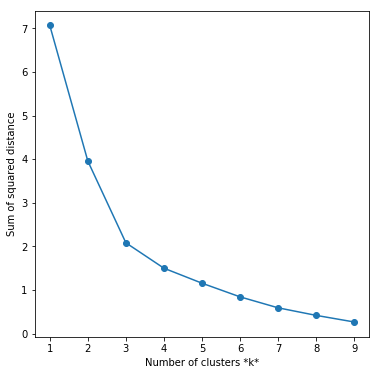

In [33]:
# run the k-means algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 10))
df_west_london_grouped_clustering = df_west_london_grouped.drop('Location', 1)

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(df_west_london_grouped_clustering)
    sse.append(km.inertia_)

# plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

We see that a good value for k would be 4. Let's get the cluster labels.

In [34]:
# set number of clusters
kclusters = 4

df_west_london_grouped_clustering = df_west_london_grouped.drop('Location', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_west_london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 3, 1, 0, 0, 3, 1, 0, 3, 3], dtype=int32)

We add the clustering labels to the dataframe with the venues.

In [35]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted

,Cluster Labels,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Aldwych,Hotel Bar,Turkish Restaurant,Beer Bar,Brasserie,Seafood Restaurant,Restaurant,Cocktail Bar,Tapas Restaurant,Gourmet Shop,Café
1,3,Bayswater,Steakhouse,Restaurant,French Restaurant,Seafood Restaurant,Cocktail Bar,Dim Sum Restaurant,Hotel Bar,Turkish Restaurant,Gourmet Shop,Beer Bar
2,1,Bedford Park,French Restaurant,Turkish Restaurant,Tapas Restaurant,Beer Bar,Brasserie,Café,Chinese Restaurant,Cocktail Bar,Cycle Studio,Dim Sum Restaurant
3,0,Bloomsbury,Szechuan Restaurant,Cocktail Bar,Hotel Bar,Tapas Restaurant,Turkish Restaurant,Gourmet Shop,Beer Bar,Brasserie,Café,Chinese Restaurant
4,0,Charing Cross,Hotel Bar,Turkish Restaurant,Beer Bar,Brasserie,Seafood Restaurant,Restaurant,Cocktail Bar,Tapas Restaurant,Gourmet Shop,Café
5,3,Chinatown,Hotel Bar,French Restaurant,Cocktail Bar,Lounge,Modern European Restaurant,Nightclub,Cycle Studio,Italian Restaurant,Gastropub,Seafood Restaurant
6,1,Chiswick,French Restaurant,Turkish Restaurant,Tapas Restaurant,Beer Bar,Brasserie,Café,Chinese Restaurant,Cocktail Bar,Cycle Studio,Dim Sum Restaurant
7,0,Covent Garden,Hotel Bar,Turkish Restaurant,Beer Bar,Brasserie,Seafood Restaurant,Restaurant,Cocktail Bar,Tapas Restaurant,Gourmet Shop,Café
8,3,Ealing,Steakhouse,French Restaurant,Turkish Restaurant,Grocery Store,Beer Bar,Brasserie,Café,Chinese Restaurant,Cocktail Bar,Cycle Studio
9,3,Fitzrovia,Hotel Bar,French Restaurant,Cocktail Bar,Lounge,Modern European Restaurant,Nightclub,Cycle Studio,Italian Restaurant,Gastropub,Seafood Restaurant


Finally, we add the locations from the initial dataframe in order to be able to plot the results to a map.

In [36]:
df_west_london_merged = neighborhoods_venues_sorted
df_west_london_merged = df_west_london_merged.merge(df_west_london_locations, on='Location')
df_west_london_merged


,Cluster Labels,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
0,0,Aldwych,Hotel Bar,Turkish Restaurant,Beer Bar,Brasserie,Seafood Restaurant,Restaurant,Cocktail Bar,Tapas Restaurant,Gourmet Shop,Café,51.516510,-0.11967
1,3,Bayswater,Steakhouse,Restaurant,French Restaurant,Seafood Restaurant,Cocktail Bar,Dim Sum Restaurant,Hotel Bar,Turkish Restaurant,Gourmet Shop,Beer Bar,51.514938,-0.18049
2,1,Bedford Park,French Restaurant,Turkish Restaurant,Tapas Restaurant,Beer Bar,Brasserie,Café,Chinese Restaurant,Cocktail Bar,Cycle Studio,Dim Sum Restaurant,51.489441,-0.26194
3,0,Bloomsbury,Szechuan Restaurant,Cocktail Bar,Hotel Bar,Tapas Restaurant,Turkish Restaurant,Gourmet Shop,Beer Bar,Brasserie,Café,Chinese Restaurant,51.524502,-0.12273
4,0,Charing Cross,Hotel Bar,Turkish Restaurant,Beer Bar,Brasserie,Seafood Restaurant,Restaurant,Cocktail Bar,Tapas Restaurant,Gourmet Shop,Café,51.516510,-0.11967
5,3,Chinatown,Hotel Bar,French Restaurant,Cocktail Bar,Lounge,Modern European Restaurant,Nightclub,Cycle Studio,Italian Restaurant,Gastropub,Seafood Restaurant,51.516479,-0.14816
6,1,Chiswick,French Restaurant,Turkish Restaurant,Tapas Restaurant,Beer Bar,Brasserie,Café,Chinese Restaurant,Cocktail Bar,Cycle Studio,Dim Sum Restaurant,51.489441,-0.26194
7,0,Covent Garden,Hotel Bar,Turkish Restaurant,Beer Bar,Brasserie,Seafood Restaurant,Restaurant,Cocktail Bar,Tapas Restaurant,Gourmet Shop,Café,51.516510,-0.11967
8,3,Ealing,Steakhouse,French Restaurant,Turkish Restaurant,Grocery Store,Beer Bar,Brasserie,Café,Chinese Restaurant,Cocktail Bar,Cycle Studio,51.514069,-0.29991
9,3,Fitzrovia,Hotel Bar,French Restaurant,Cocktail Bar,Lounge,Modern European Restaurant,Nightclub,Cycle Studio,Italian Restaurant,Gastropub,Seafood Restaurant,51.516479,-0.14816


### Clusters visualization
We present the clusters on the map.

In [37]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to the map
markers_colors = ['red', 'blue', 'green', 'purple', 'orange']
for lat, lon, poi, cluster in zip(df_west_london_merged['Latitude'], df_west_london_merged['Longitude'], df_west_london_merged['Location'], df_west_london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=markers_colors[cluster-1],
        fill=True,
        fill_color=markers_colors[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Then, we get a separate dataframe per cluster to explore it.

In [38]:
# cluster 1
df_west_london_merged.loc[df_west_london_merged['Cluster Labels'] == 0, 
                          df_west_london_merged.columns[[1] + list(range(2, df_west_london_merged.shape[1]-2))]]

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aldwych,Hotel Bar,Turkish Restaurant,Beer Bar,Brasserie,Seafood Restaurant,Restaurant,Cocktail Bar,Tapas Restaurant,Gourmet Shop,Café
3,Bloomsbury,Szechuan Restaurant,Cocktail Bar,Hotel Bar,Tapas Restaurant,Turkish Restaurant,Gourmet Shop,Beer Bar,Brasserie,Café,Chinese Restaurant
4,Charing Cross,Hotel Bar,Turkish Restaurant,Beer Bar,Brasserie,Seafood Restaurant,Restaurant,Cocktail Bar,Tapas Restaurant,Gourmet Shop,Café
7,Covent Garden,Hotel Bar,Turkish Restaurant,Beer Bar,Brasserie,Seafood Restaurant,Restaurant,Cocktail Bar,Tapas Restaurant,Gourmet Shop,Café
13,Holborn,Szechuan Restaurant,Cocktail Bar,Hotel Bar,Tapas Restaurant,Turkish Restaurant,Gourmet Shop,Beer Bar,Brasserie,Café,Chinese Restaurant
15,King's Cross,Szechuan Restaurant,Cocktail Bar,Hotel Bar,Tapas Restaurant,Turkish Restaurant,Gourmet Shop,Beer Bar,Brasserie,Café,Chinese Restaurant
23,St Giles,Hotel Bar,Turkish Restaurant,Beer Bar,Brasserie,Seafood Restaurant,Restaurant,Cocktail Bar,Tapas Restaurant,Gourmet Shop,Café
24,St Pancras,Szechuan Restaurant,Cocktail Bar,Hotel Bar,Tapas Restaurant,Turkish Restaurant,Gourmet Shop,Beer Bar,Brasserie,Café,Chinese Restaurant
25,West Kensington,Hotel,Cocktail Bar,Restaurant,Hotel Bar,Grocery Store,Beer Bar,Brasserie,Café,Chinese Restaurant,Cycle Studio


In [39]:
# cluster 2
df_west_london_merged.loc[df_west_london_merged['Cluster Labels'] == 1, 
                          df_west_london_merged.columns[[1] + list(range(2, df_west_london_merged.shape[1]-2))]]

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Bedford Park,French Restaurant,Turkish Restaurant,Tapas Restaurant,Beer Bar,Brasserie,Café,Chinese Restaurant,Cocktail Bar,Cycle Studio,Dim Sum Restaurant
6,Chiswick,French Restaurant,Turkish Restaurant,Tapas Restaurant,Beer Bar,Brasserie,Café,Chinese Restaurant,Cocktail Bar,Cycle Studio,Dim Sum Restaurant
10,Grove Park,French Restaurant,Turkish Restaurant,Tapas Restaurant,Beer Bar,Brasserie,Café,Chinese Restaurant,Cocktail Bar,Cycle Studio,Dim Sum Restaurant
11,Gunnersbury,French Restaurant,Turkish Restaurant,Tapas Restaurant,Beer Bar,Brasserie,Café,Chinese Restaurant,Cocktail Bar,Cycle Studio,Dim Sum Restaurant


In [40]:
# cluster 3
df_west_london_merged.loc[df_west_london_merged['Cluster Labels'] == 2, 
                          df_west_london_merged.columns[[1] + list(range(2, df_west_london_merged.shape[1]-2))]]

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Hammersmith,Gastropub,Tapas Restaurant,Cocktail Bar,Turkish Restaurant,Beer Bar,Brasserie,Café,Chinese Restaurant,Cycle Studio,Dim Sum Restaurant
16,Little Venice,Gastropub,Turkish Restaurant,Tapas Restaurant,Beer Bar,Brasserie,Café,Chinese Restaurant,Cocktail Bar,Cycle Studio,Dim Sum Restaurant
17,Maida Vale,Gastropub,Turkish Restaurant,Tapas Restaurant,Beer Bar,Brasserie,Café,Chinese Restaurant,Cocktail Bar,Cycle Studio,Dim Sum Restaurant


In [41]:
# cluster 4
df_west_london_merged.loc[df_west_london_merged['Cluster Labels'] == 3, 
                          df_west_london_merged.columns[[1] + list(range(2, df_west_london_merged.shape[1]-2))]]

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bayswater,Steakhouse,Restaurant,French Restaurant,Seafood Restaurant,Cocktail Bar,Dim Sum Restaurant,Hotel Bar,Turkish Restaurant,Gourmet Shop,Beer Bar
5,Chinatown,Hotel Bar,French Restaurant,Cocktail Bar,Lounge,Modern European Restaurant,Nightclub,Cycle Studio,Italian Restaurant,Gastropub,Seafood Restaurant
8,Ealing,Steakhouse,French Restaurant,Turkish Restaurant,Grocery Store,Beer Bar,Brasserie,Café,Chinese Restaurant,Cocktail Bar,Cycle Studio
9,Fitzrovia,Hotel Bar,French Restaurant,Cocktail Bar,Lounge,Modern European Restaurant,Nightclub,Cycle Studio,Italian Restaurant,Gastropub,Seafood Restaurant
14,Holland Park,French Restaurant,Grocery Store,Sushi Restaurant,Chinese Restaurant,Cocktail Bar,Italian Restaurant,Turkish Restaurant,Beer Bar,Brasserie,Café
18,Marylebone (also St Marylebone),Hotel Bar,French Restaurant,Cocktail Bar,Lounge,Modern European Restaurant,Nightclub,Cycle Studio,Italian Restaurant,Gastropub,Seafood Restaurant
19,Mayfair,Hotel Bar,French Restaurant,Cocktail Bar,Lounge,Modern European Restaurant,Nightclub,Cycle Studio,Italian Restaurant,Gastropub,Seafood Restaurant
20,Notting Hill,Asian Restaurant,Gourmet Shop,Café,Social Club,Cocktail Bar,Movie Theater,Diner,Italian Restaurant,Gastropub,Beer Bar
21,Paddington,Steakhouse,Restaurant,French Restaurant,Seafood Restaurant,Cocktail Bar,Dim Sum Restaurant,Hotel Bar,Turkish Restaurant,Gourmet Shop,Beer Bar
22,Soho,Hotel Bar,French Restaurant,Cocktail Bar,Lounge,Modern European Restaurant,Nightclub,Cycle Studio,Italian Restaurant,Gastropub,Seafood Restaurant


## 4. Results
From the individual dataframes per cluster, we can identify what are the common attributes of the venues in the cluster. Thus, we have the following:

* In cluster 1, we see that the most common venue is Gastrobub followed by Turkish restaurant as the second most common venue. Locations in cluster 1 are not very interesting for us as the most common venues serve food.
* In cluster 2, the three most common venues are French , Turkish , and Tapas restaurants. Again, these are not the locations that we would consider.
* In cluster 3, the most common venue is Lounge. However, the second most common is Turkish restaurant. So, we may consider locations in this cluster, but further analysis is required to closely evaluate the competition and decide to proceed or not.
* In cluster 4, we see that the most common venue is either a hotel bar or Asian restaurant. There are also various types of venues as second most common ones. This, makes this cluster the most interesting of all, since there is space for the new restaurant we want to open. The locations in this cluster are the first we would further examine in order to reach a final decision.

## 5. Conclusion

Using date from a variety of sources, we evaluated the neighbourhoods of West London in order to find the most appropriate ones in order to open a Mediterranean fusion restaurant.

In our analysis, we concluded to the subset of areas that seems the most promising. However, these data are not enough for a final decision and work more as a guide. Further analysis, both quantitative and qualitive, is required in order to limit the number of potentials areas of interest. 

Such analysis would include computations regarding distances among competing restaurants, distances from means of public transport, distances from suppliers, etc. Also, the cost of lease and the availability of spaces to open a restaurant are important factors.

Finally, qualitive metrics such as customer satisfaction from existing restaurants, customer perception of each neighbourhood, etc would also affect the final decision.